# Bag-Level Representation with Adaboost

## Set-up

In [216]:
# import dependencies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve, average_precision_score

In [17]:
# split the data into 5 folds
# seed = 1
# np.random.seed(seed)
!python separating_folds.py

In [18]:
df = pd.read_csv("training_data.csv")

## Feature Engineering

In [22]:
def kurt(x):
    return x.kurt()

agg_funcs = {
    "time_1": ["mean", "std", "sem", "skew", kurt, "max", "min"],
    "stddev_1": ["mean", "std", "sem", "skew", kurt, "max", "min"],
    "mean_current_1": ["mean", "std", "sem", "skew", kurt, "max", "min"],
    "time_2": ["mean", "std", "sem", "skew", kurt, "max", "min"],
    "stddev_2": ["mean", "std", "sem", "skew", kurt, "max", "min"],
    "mean_current_2": ["mean", "std", "sem", "skew", kurt, "max", "min"],
    "time_3": ["mean", "std", "sem", "skew", kurt, "max", "min"],
    "stddev_3": ["mean", "std", "sem", "skew", kurt, "max", "min"],
    "mean_current_3": ["mean", "std", "sem", "skew", kurt, "max", "min"],
    "label": ["mean"],
    'folds': ["mean"]
}

In [24]:
result = df.groupby(["gene_id", "transcript_id","transcript_position"], as_index=False).agg(agg_funcs)
result.columns = [f'{col[0]}_{col[1]}' for col in result.columns]
result = result.rename(columns={"label_mean": "label", "folds_mean":"folds"})
result['label'] = result['label'].astype(int)
result['folds'] = result['folds'].astype(int)

In [25]:
result.head()

,gene_id_,transcript_id_,transcript_position_,time_1_mean,time_1_std,time_1_sem,time_1_skew,time_1_kurt,time_1_max,time_1_min,...,stddev_3_min,mean_current_3_mean,mean_current_3_std,mean_current_3_sem,mean_current_3_skew,mean_current_3_kurt,mean_current_3_max,mean_current_3_min,label,folds
0,ENSG00000000003,ENST00000373020,512,0.007247,0.004404,0.000985,1.084484,-0.127559,0.0169,0.00266,...,0.917,92.330000,2.258574,0.505033,-3.353925,13.491952,94.5,83.5,0,2
1,ENSG00000000003,ENST00000373020,689,0.009868,0.006946,0.001516,1.311306,0.969305,0.0279,0.00232,...,1.350,89.385714,2.113122,0.461121,-0.689415,0.862216,93.5,84.3,0,2
2,ENSG00000000003,ENST00000373020,823,0.007456,0.003799,0.000829,1.907891,4.444759,0.0196,0.00299,...,1.460,88.176190,2.420517,0.528200,0.358926,-0.426787,93.1,84.7,0,2
3,ENSG00000000003,ENST00000373020,830,0.007765,0.004869,0.001089,1.781124,3.707942,0.0226,0.00266,...,1.210,80.110000,1.523120,0.340580,0.589444,0.070561,83.8,77.9,0,2
4,ENSG00000000003,ENST00000373020,849,0.006785,0.003115,0.000680,2.533371,8.574765,0.0181,0.00332,...,1.100,84.657143,2.048798,0.447084,1.475521,2.519809,90.7,82.3,0,2


In [26]:
result.shape

(121838, 68)

In [27]:
result.to_csv("fe_data.csv")

## Model Training

### Initialisation

In [ ]:
data = result

In [129]:
num_folds = 5

# hyperparameters to tune for
base_estimators = [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2)]
n_estimators = [50, 100]
learning_rates = [0.01, 0.1, 1.0]
num_combinations = len(base_estimators)*len(n_estimators)*len(learning_rates)

# to store the predictions from each set of hyperparameters on each fold
preds = [[None for _ in range(num_combinations)] for _ in range(num_folds)]

# store column names of preds
col_names = []
for base_estimator in base_estimators:
        for n_estimator in n_estimators:
            for learning_rate in learning_rates:
                col_names.append([base_estimator, n_estimator, learning_rate])
col_names

[[DecisionTreeClassifier(max_depth=1), 50, 0.01],
 [DecisionTreeClassifier(max_depth=1), 50, 0.1],
 [DecisionTreeClassifier(max_depth=1), 50, 1.0],
 [DecisionTreeClassifier(max_depth=1), 100, 0.01],
 [DecisionTreeClassifier(max_depth=1), 100, 0.1],
 [DecisionTreeClassifier(max_depth=1), 100, 1.0],
 [DecisionTreeClassifier(max_depth=2), 50, 0.01],
 [DecisionTreeClassifier(max_depth=2), 50, 0.1],
 [DecisionTreeClassifier(max_depth=2), 50, 1.0],
 [DecisionTreeClassifier(max_depth=2), 100, 0.01],
 [DecisionTreeClassifier(max_depth=2), 100, 0.1],
 [DecisionTreeClassifier(max_depth=2), 100, 1.0]]

### Manual Hyperparameter Tuning

In [132]:
for fold in range(1,num_folds+1):
    row = fold - 1
    col = 0
    train_data = data[data["folds"]!=fold]
    test_data = data[data["folds"]==fold]
    X_train = train_data.loc[:, "time_1_mean":"mean_current_3_min"]
    y_train = train_data.loc[:, "label"]
    X_test = test_data.loc[:, "time_1_mean":"mean_current_3_min"]
    y_test = test_data.loc[:, "label"]

    minority_perc = sum(y_test==1) / len(y_test)
    sample_weights = [1.0 if label==0 else 1/minority_perc for label in y_train]
    
    for base_estimator in base_estimators:
        for n_estimator in n_estimators:
            for learning_rate in learning_rates:
                adaboost_classifier = AdaBoostClassifier(base_estimator=base_estimator,
                                                         n_estimators=n_estimator,
                                                         learning_rate=learning_rate)
                adaboost_classifier.fit(X_train, y_train, sample_weight=sample_weights)
                
                class_probabilities = adaboost_classifier.predict_proba(X_test)
                y_scores = adaboost_classifier.predict_proba(X_test)[:, 1]  # probability of class 1
                preds[row][col] = y_scores
                col += 1
                print(row, col)

0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12


## Models Evaluation

#### Metrics Computation

In [150]:
accuracy = np.zeros(shape=(num_folds, num_combinations))
balanced_accuracy = np.zeros(shape=(num_folds, num_combinations))    # average of recall obtained on each class
precision = np.zeros(shape=(num_folds, num_combinations))
recall = np.zeros(shape=(num_folds, num_combinations))
f1 = np.zeros(shape=(num_folds, num_combinations))
roc_auc = np.zeros(shape=(num_folds, num_combinations))    # area under the ROC curve
average_precision = np.zeros(shape=(num_folds, num_combinations))    # area under the Precision-Recall curve


for fold in range(1, num_folds+1):
    train_data = data[data["folds"]!=fold]
    test_data = data[data["folds"]==fold]
    y_train = train_data.loc[:, "label"]
    y_true = test_data.loc[:, "label"]
    # minority_perc = sum(y_true==1) / len(y_true)
    # sample_weight = [1.0 if label==0 else 1/minority_perc for label in y_train]
    row = fold - 1
    
    for col in range(num_combinations):
        y_pred = preds[row][col]
        roc_auc[row,col] = roc_auc_score(y_true, y_pred)     
        average_precision[row,col] = average_precision_score(y_true, y_pred)     
        
        # using decision rule of 0.5
        threshold = 0.5
        y_pred_label =  np.array([1 if prob>threshold else 0 for prob in y_pred])
        accuracy[row,col] = accuracy_score(y_true, y_pred_label)
        # balanced_accuracy[row,col] = balanced_accuracy_score(y_true, y_pred_label, sample_weight)
        balanced_accuracy[row,col] = balanced_accuracy_score(y_true, y_pred_label)
        precision[row,col] = precision_score(y_true, y_pred_label)
        recall[row,col] = recall_score(y_true, y_pred_label)
        f1[row,col] = f1_score(y_true, y_pred_label)

In [151]:
# averaged across all 5 folds
avg_accuracy = np.mean(accuracy, axis=0)
avg_balanced_accuracy = np.mean(balanced_accuracy, axis=0)    
avg_precision = np.mean(precision, axis=0)
avg_recall = np.mean(recall, axis=0)
avg_f1 = np.mean(f1, axis=0)
avg_roc_auc = np.mean(roc_auc, axis=0)
avg_average_precision = np.mean(average_precision, axis=0)

#### Plots

In [222]:
legend_labels = []
for i in col_names:
    decision_tree_depth = str(i[0])[-2]
    n_estimators = str(i[1])
    learning_rate = str(i[2])
    label = "decision_tree_depth=" + decision_tree_depth + ", " + "n_estimators=" + n_estimators + ", " + "learning_rate=" + learning_rate
    legend_labels.append(label)
    
metrics_dict = {'legend_label': legend_labels,
                'base_estimator': np.array(col_names)[:,0].astype(str),
                'n_estimators': np.array(col_names)[:,1],
                'learning_rate': np.array(col_names)[:,2],
                'accuracy': avg_accuracy, 
                'balanced_accuracy': avg_balanced_accuracy, 
                'precision': avg_precision,
                'recall': avg_recall,
                'f1': avg_f1,
                'roc_auc': avg_roc_auc,
                'average_precision': avg_average_precision}
metrics_df = pd.DataFrame(data=metrics_dict)
long_metrics_df = pd.melt(metrics_df, id_vars=['legend_label','base_estimator','n_estimators','learning_rate'], 
                          var_name='Metric', value_name='Score')

##### Interactive Plot

In [231]:
fig = px.line(long_metrics_df, x='Metric', y='Score',
              color='legend_label',
              labels={'Metric': 'Metric', 'Score': 'Score', 'legend_label': 'Hyperparameter Combination'},
              title='Metric Scores for Each Unique Hyperparameter Combination')
fig.show()

##### Static Plot

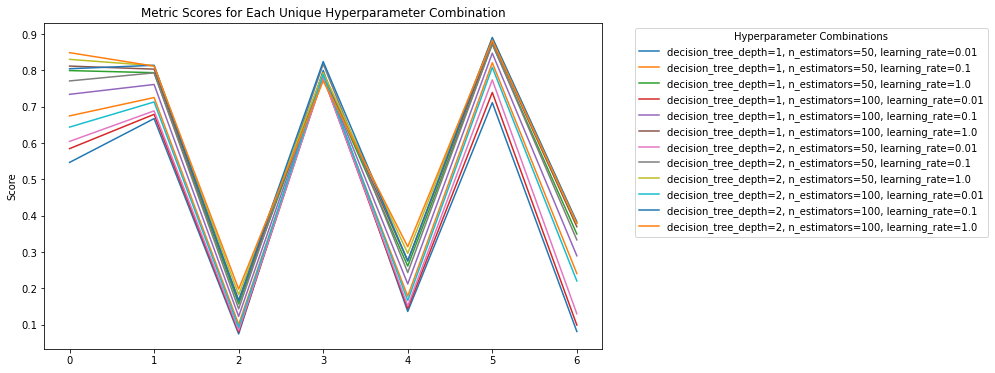

In [235]:
plt.figure(figsize=(10, 6))

for group_name, group_data in metrics_df.groupby(["base_estimator", "n_estimators", "learning_rate"]):
    decision_tree_depth = group_name[0][-2]
    n_estimators = str(group_name[1])
    learning_rate = str(group_name[2])
    label = "decision_tree_depth=" + decision_tree_depth + ", " + "n_estimators=" + n_estimators + ", " + "learning_rate=" + learning_rate
    metrics = group_data.loc[:,"accuracy":"average_precision"]
    plt.plot(range(len(metrics.columns)), metrics.values[0], label=label)

plt.legend(title="Hyperparameter Combinations", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.ylabel("Score")
plt.title("Metric Scores for Each Unique Hyperparameter Combination")
plt.show()

## Model Selection

From the interactive plot, we select the model with decision_tree_depth=2, n_estimators=100, learning_rate=1.0 for now.

In [299]:
long_metrics_df[long_metrics_df["legend_label"]=="decision_tree_depth=2, n_estimators=100, learning_rate=1.0"].loc[:,"Metric":].reset_index(drop=True)

,Metric,Score
0,accuracy,0.848898
1,balanced_accuracy,0.811853
2,precision,0.198306
3,recall,0.771103
4,f1,0.314828
5,roc_auc,0.883269
6,average_precision,0.378746


##### AUC-ROC Curve and Precision-Recall Curve (5-Fold)

In [300]:
# selected model is the last combination
selected_model_prob = [i[-1] for i in preds]

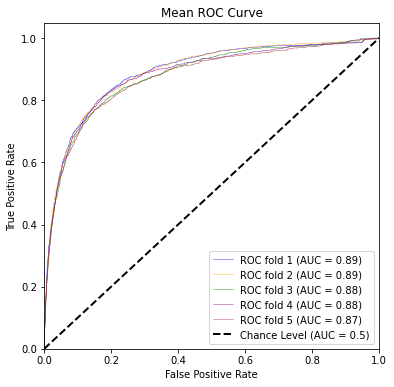

In [301]:
fig, ax = plt.subplots(figsize=(6, 6))
fold_colors = ["blue","orange","green","purple","brown"]


for i in range(num_folds):
    test_data = data[data["folds"]==i+1]
    y_test = test_data.loc[:, "label"]
    y_pred_probs = selected_model_prob[i]

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=fold_colors[i], lw=0.5, alpha=0.8, label=f'ROC fold {i+1} (AUC = {roc_auc:.2f})')


plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label="Chance Level (AUC = 0.5)")
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

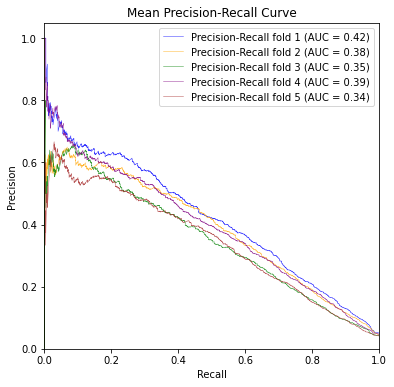

In [302]:
fig, ax = plt.subplots(figsize=(6, 6))
fold_colors = ["blue","orange","green","purple","brown"]


for i in range(num_folds):
    test_data = data[data["folds"]==i+1]
    y_test = test_data.loc[:, "label"]
    y_pred_probs = selected_model_prob[i]

    precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)
    pr_auc = average_precision_score(y_test, y_pred_probs)    
    plt.plot(recall, precision, color=fold_colors[i], lw=0.5, alpha=0.8, label=f'Precision-Recall fold {i+1} (AUC = {pr_auc:.2f})')


plt.legend(loc='upper right')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Mean Precision-Recall Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

# Extras

## Hyperparameter Tuning with GridSearch 

An alternative approach is to employ GridSearch for automated hyperparameter tuning. However, it lacks the capability to integrate the sample weights computed for each cross-validation fold.

In [92]:
X = data.loc[:, "time_1_mean":"mean_current_3_min"]
y = data.loc[:, "label"]


custom_cv_splits = []
for fold_id in range(1, 6):
    train_indices = data[data['folds'] != fold_id].index
    test_indices = data[data['folds'] == fold_id].index
    custom_cv_splits.append((train_indices, test_indices))
    
    # minority_perc = sum(y[train_indices]==1) / len(train_indices)
    # class_weights = {0: 1.0, 1: 1/minority_perc}
    # sample_weights = np.array([class_weights[y] for y in data.loc[train_indices, 'label']])
    # custom_cv_splits.append((train_indices, test_indices, sample_weights))


param_grid = {
    'base_estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2)],
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1, 1.0]
}


adaboost_classifier = AdaBoostClassifier(random_state=seed)
grid_search = GridSearchCV(adaboost_classifier, param_grid, cv=custom_cv_splits, scoring='average_precision', n_jobs=-1)
grid_search.fit(X, y)


# get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}
